In [1]:
data_dir = '/scratch/fs999/shamoutlab/data/mimic-iv-extracted/'
img_dir = '/scratch/fs999/shamoutlab/data/physionet.org/files//mimic-cxr-jpg/2.0.0'
code_dir = '/scratch/se1525/mml-ssl'
task = 'phenotyping'

# Import libraries

import os
import numpy as np
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset
import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Import custom functions
import custom_parser as par
import data_utils as prep


In [2]:
parser = par.initiate_parsing()
        

args = parser.parse_args(['--save_dir', '/scratch/fs999/shamoutlab/Farah/contrastive-learning-results/checkpoints/phenotyping/models',
'--vision-backbone', 'resnet34' ,
'--epochs', '300', '--transforms_cxr', 'simclrv2', '--temperature', '0.01',
'--load_state', 'SIMCLR-760276_epoch_148', #'T-SIMCLR-1042373_epoch_20'
'--batch_size', '1', '--lr' ,'0.5' ,
'--pretrain_type' ,'simclr' , '--width', '1',
'--mode' ,'train' ,
'--fusion_type', 'None', '--beta_infonce', '--fusion_layer' , '0']) #, 

In [3]:
img_dir = args.cxr_data_root+'/resized/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg'
orig_img = Image.open(img_dir).convert('RGB')

In [4]:
def plot(imgs, with_orig=True, row_title=None):
    num_cols = len(imgs)
    fig, axs = plt.subplots(nrows=1, ncols=num_cols, squeeze=False,figsize=(50,50))
    for i in range(0, len(imgs)):
        ax = axs[0, i]
        ax.imshow(imgs[i].permute(1,2,0))
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=row_title[i])
        
    plt.rcParams.update({'font.size': 30})
    plt.tight_layout()

torch.Size([3, 224, 224])


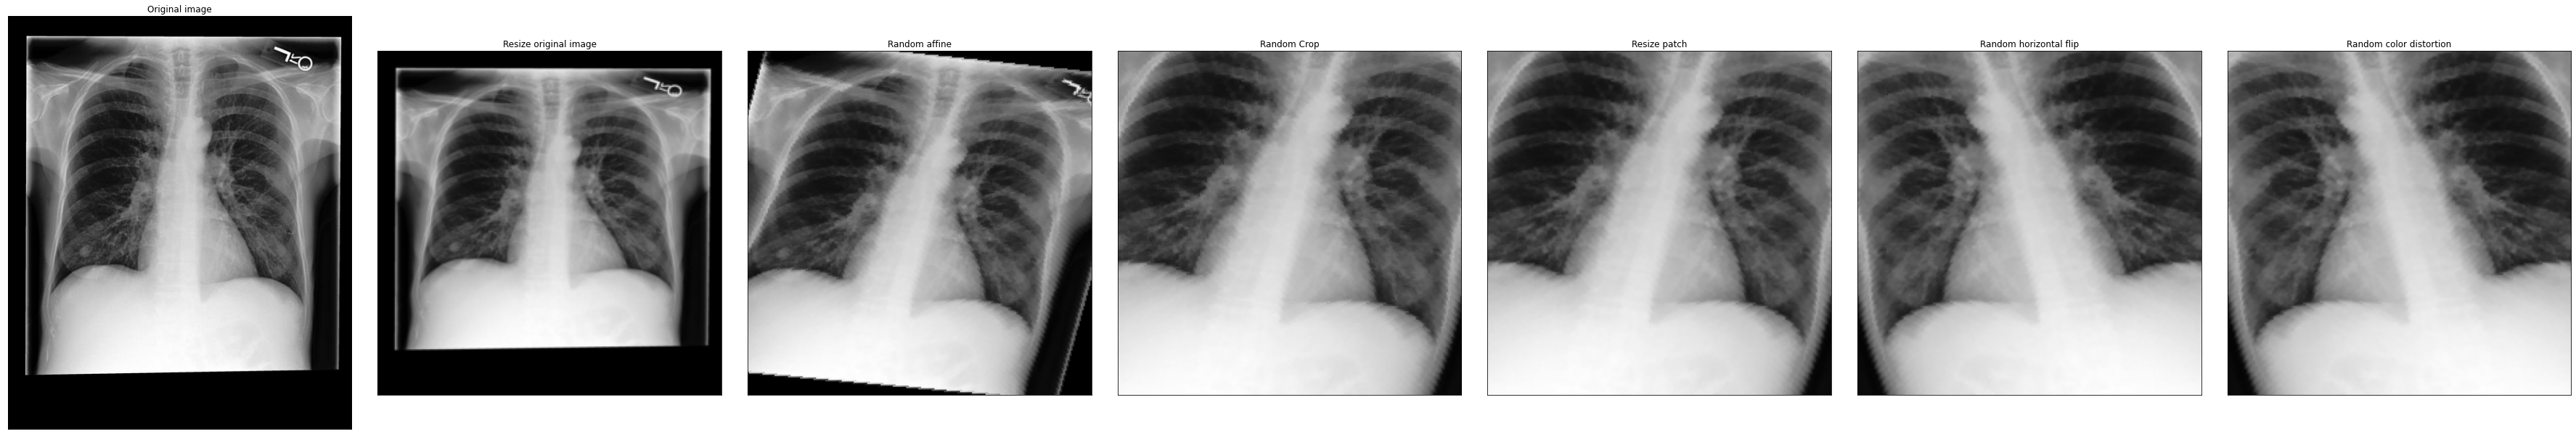

In [5]:
class RandomCrop(object):
    "Randomly crop an image"
    
    def __call__(self, sample):
        resize = 256
        #print(np.random.uniform(0.4*resize,resize,1))
        random_crop_size = int(np.random.uniform(0.6*resize,resize,1))
        sample=transforms.RandomCrop(random_crop_size)(sample)
        return sample
    
    
class RandomColorDistortion(object):
    "Apply random color distortions to the image"
    
    def __call__(self, sample):
        resize=256

        # Random color distortion
        strength = 1.0 # 1.0 imagenet setting and CIFAR uses 0.5
        brightness = 0.8 * strength 
        contrast = 0.8 * strength
        saturation = 0.8 * strength
        hue = 0.2 * strength
        prob = np.random.uniform(0,1,1) 
        if prob < 0.8:
            sample=transforms.ColorJitter(brightness, contrast, saturation, hue)(sample)

        # Random Grayscale
        sample=transforms.RandomGrayscale(p=0.2)(sample)

        # Gaussian blur also based on imagenet but not used for CIFAR
        #prob = np.random.uniform(0,1,1)
        #if prob < 0.3:
        #    sample=transforms.GaussianBlur(kernel_size=resize//10)(sample)
        #    sample=transforms.Pad(0)(sample)
        return sample 
    
# Note this function needs to be editted to mimic function above 
def visualize_transforms_simclr(args, orig_img, split='train'):
    # Create array of images 
    new_images = [orig_img]
    tt = ['Original image']
    #normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    if split == 'train':
        # Resize all images to same size
        new_images = new_images + [transforms.Resize([args.resize, args.resize])(orig_img)]
        tt = tt + ['Resize original image']
        # Random affine
        new_images = new_images + [transforms.RandomAffine(degrees=(-45, 45), translate=(0.1,0.1), scale=(0.7, 1.5), shear=(-25, 25))(new_images[-1])]
        tt = tt + ['Random affine']
        # Random crop
        new_images = new_images + [RandomCrop()(new_images[-1])]
        tt = tt + ['Random Crop']
        # Resize to 224 x 224
        new_images = new_images + [transforms.Resize([224,224], interpolation=3)(new_images[-1])]
        tt = tt + ['Resize patch']
        # Random horizontal flip 
        new_images = new_images + [transforms.RandomHorizontalFlip()(new_images[-1])]
        tt = tt + ['Random horizontal flip']
        # Random color distortions
        new_images = new_images + [RandomColorDistortion()(new_images[-1])]
        tt = tt + ['Random color distortion']
        
        # Convert all to tensors
        for i in range(0, len(new_images)):
            new_images[i]=transforms.ToTensor()(new_images[i])
    return new_images, tt

img_array, titles = visualize_transforms_simclr(args, orig_img)
print(img_array[-1].shape) 
plot(img_array, row_title = titles)

torch.Size([3, 224, 224])


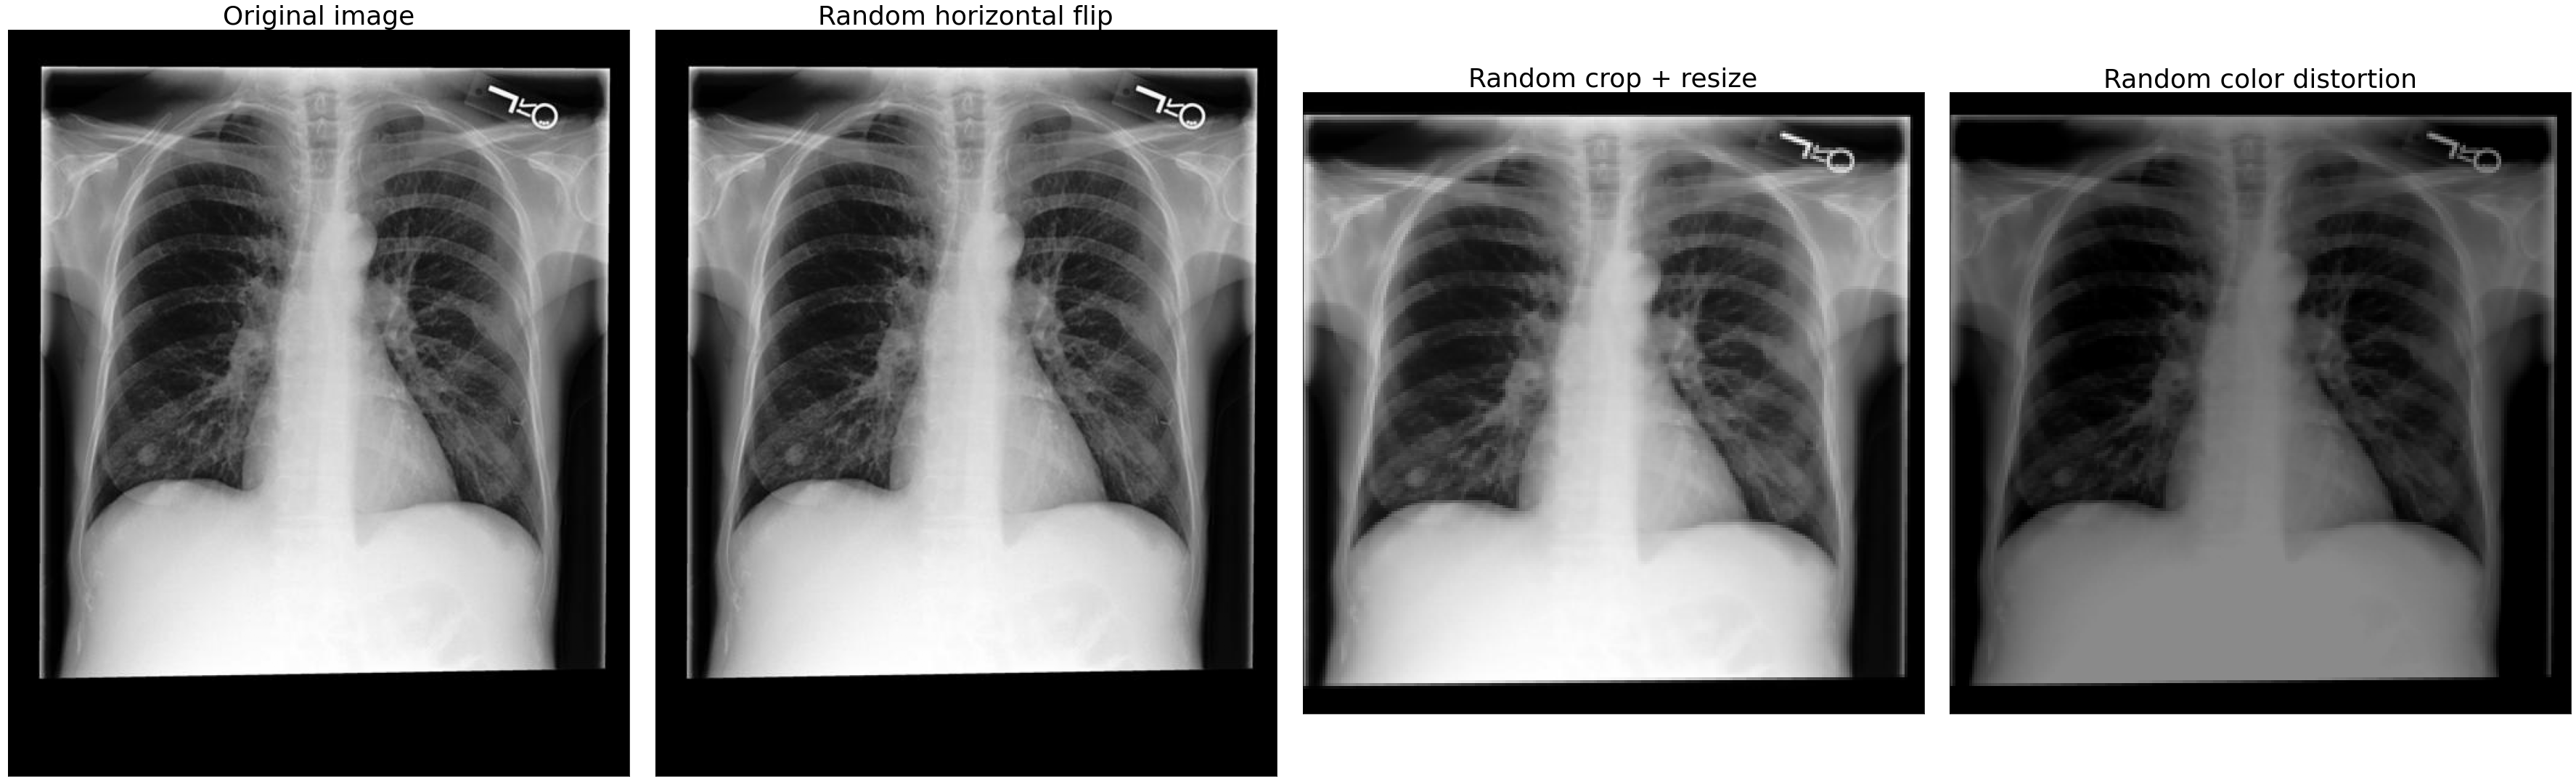

In [6]:

def visualize_transforms_simclr_2(args, orig_img, split='train'):
    # Create array of images 
    new_images = [orig_img]
    tt = ['Original image']
    #normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    if split == 'train':
        # Random horizontal flip 
        new_images = new_images + [transforms.RandomHorizontalFlip()(orig_img)]
        tt = tt + ['Random horizontal flip']
        # Random resize + crop 
        new_images = new_images + [transforms.RandomResizedCrop(224,(0.8,1.0))(new_images[-1])]
        tt = tt + ['Random crop + resize']
        # Random color distortions
        new_images = new_images + [RandomColorDistortion()(new_images[-1])]
        tt = tt + ['Random color distortion']
        
        # Convert all to tensors
        for i in range(0, len(new_images)):
            new_images[i]=transforms.ToTensor()(new_images[i])
#         # Clip values between 0 and 1 and normalize
#         new_images = new_images + [Clip()(new_images[-1])]
#         tt = tt + ['Clip values (0,1)']
#         # Normalize values
#         new_images = new_images + [normalize(new_images[-1])]
#         tt = tt + ['Normalize values']
    return new_images, tt
img_array, titles = visualize_transforms_simclr_2(args, orig_img)
print(img_array[-1].shape) 
plot(img_array, row_title = titles)